# Set connection with GitHub

In [1]:
# ! cd /kaggle/working && rm -rf RECsys_Challenge2024

In [2]:
from kaggle_secrets import UserSecretsClient

token = UserSecretsClient().get_secret("Token")

! git clone https://{token}@github.com/madratak/RECsys_Challenge2024.git

Cloning into 'RECsys_Challenge2024'...
remote: Enumerating objects: 5840, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 5840 (delta 45), reused 11 (delta 3), pack-reused 5707 (from 3)
Receiving objects: 100% (5840/5840), 390.97 MiB | 37.79 MiB/s, done.
Resolving deltas: 100% (3268/3268), done.
Updating files: 100% (479/479), done.


In [3]:
! pip install PyGithub requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 31.7 MB/s eta 0:00:00


In [4]:
! pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 64.1 MB/s eta 0:00:00


In [5]:
%cd /kaggle/working/RECsys_Challenge2024
! python run_compile_all_cython.py

/kaggle/working/RECsys_Challenge2024
run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/usr/bin/python3'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1252:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disabl

In [6]:
from Utils.notebookFunctions import *
from Utils.xgboost_functions import *
import numpy as np
import pandas as pd
import scipy.sparse as sps
import time
import shutil
import optuna
import json
import os
import gc
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
from tqdm import tqdm
from xgboost import XGBRanker

import warnings
import string
from scipy.stats import skew, kurtosis
from numpy import linalg as LA

%matplotlib inline
from xgboost import plot_importance

K_PATH = '/kaggle/working/RECsys_Challenge2024'
GH_PATH = 'TrainedModels/WithoutKFCV'
D_PATH = 'XGBoost'

np.random.seed(42)

In [7]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.MatrixFactorization.FasterIALSRecommender import FasterIALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import ScaledPureSVDRecommender
from Recommenders.Neural.MultVAE_PyTorch_Recommender import MultVAERecommender_PyTorch_OptimizerMask 
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python

## Import the repository

In [8]:
repo = get_repo_from_github(token)

Repository 'RECsys_Challenge2024' found.


In [9]:
config = {
    'model': 'XGBoostNoCont',
    'metric': 'MAP',
    'categorical': True,
    'contents': False,
    'tune_parameters': False,
    'database_path': '/kaggle/working/history_XGBoostNoCont_MAP.db',
    'copy_prev_best_params': False,
    'tune_best_params': True,
    'save_github': True
}

Import the database where previous tuning trials have been saved.

In [10]:
try:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Construction of URM and ICM matrices

In [11]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")

n_users = len(URM_all_dataframe["user_id"].unique())
n_items = len(URM_all_dataframe["item_id"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)),
                        shape = (n_users, n_items))

URM_all

<35736x38121 sparse matrix of type '<class 'numpy.float64'>'
	with 1764607 stored elements in Compressed Sparse Row format>

In [12]:
ICM_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")

n_items = len(ICM_dataframe["item_id"].unique())
n_features = len(ICM_dataframe["feature_id"].unique())

ICM_all = sps.csr_matrix((ICM_dataframe["data"].values, 
                          (ICM_dataframe["item_id"].values, ICM_dataframe["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all

<38121x94331 sparse matrix of type '<class 'numpy.float64'>'
	with 2940040 stored elements in Compressed Sparse Row format>

## Import dataframes

In [13]:
dataframes_path = f'/kaggle/input/dataframes-{config["model"].lower()}'

if os.path.exists(dataframes_path):
    print("Dataframe directory is ready to be used.")
else:
    print("No dataframes directory is present.")

Dataframe directory is ready to be used.


# Training
Split the dataset in train, validation and test set.

In [14]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


Function to fit the hybrid recommender that is going to be used as candidate generator.

## Candidate Generators

Select the best previously trained recommenders to use inside the hybrid recommender (candidate generator).

In [15]:
cg_recommenders = {
    "ItemKNNCF": ItemKNNCFRecommender,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "RP3beta": RP3betaRecommender,
}

## Features
Select the other previously trained recommenders to use them as features.

In [16]:
f_recommenders = {
    "RP3beta": RP3betaRecommender,
    "P3alpha": P3alphaRecommender,
    "ItemKNNCF": ItemKNNCFRecommender,
    "ItemKNNCBF": ItemKNNCBFRecommender,
    "UserKNNCF": UserKNNCFRecommender,
    "FasterIALS": FasterIALSRecommender,
    "NMF": NMFRecommender,
    "PureSVDItem": PureSVDItemRecommender,
    "ScaledPureSVD": ScaledPureSVDRecommender,
    "MultVAE": MultVAERecommender_PyTorch_OptimizerMask,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "SLIM_BPR": SLIM_BPR_Python,
}

## Training dataframe building
Build the dataframe with the predictions, the popularity of the item, the user activity, the profile length, item features and others.

Then, set features and target to use for the training.

In [17]:
if config["tune_parameters"]:
    
    if os.path.exists(dataframes_path + f'/training_dataframe_{config["model"]}.parquet'):
        training_dataframe = pd.read_parquet(dataframes_path + f'/training_dataframe_{config["model"]}.parquet')
        groups_train = training_dataframe.groupby("UserID").size().values
        print("training_dataframe and groups_train loaded.")
    
    else:
        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "Train", URM_train, ICM_all, cg_recommenders, GH_PATH, "cg", repo)
    
        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "Train", URM_train, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        training_dataframe, groups_train = create_XGBoost_dataframe(URM_train, candidate_generator_recommenders, features_recommenders, ICM_all, URM_validation, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        training_dataframe.to_parquet(f'/kaggle/working/training_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders
        
    display(training_dataframe)

    y_train = training_dataframe["Label"]
    X_train = training_dataframe.drop(columns=["Label"])

    del training_dataframe

## Validation and Testing dataframe building

The first dataset excludes the label column since it is used to evaluate the performance of the model with the hyperparameters chosen by Optuna. In contrast, the second dataset includes the label column and is used to train the final model selected by Optuna.

In [18]:
if config["tune_parameters"] or config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/testing_dataframe_{config["model"]}.parquet' ):
        testing_dataframe = pd.read_parquet(dataframes_path + f'/testing_dataframe_{config["model"]}.parquet')
        groups_test = testing_dataframe.groupby("UserID").size().values
        print("testing_dataframe and groups_test loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "TrainVal", URM_train + URM_validation, ICM_all, cg_recommenders, GH_PATH, "cg", repo)

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainVal", URM_train + URM_validation, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        testing_dataframe, groups_test = create_XGBoost_dataframe(URM_train + URM_validation, candidate_generator_recommenders, features_recommenders, ICM_all, URM_test, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        testing_dataframe.to_parquet(f'/kaggle/working/testing_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders

    if config["tune_parameters"]:
        validation_dataframe = testing_dataframe.drop(columns=["Label"])
        display(validation_dataframe)

testing_dataframe and groups_test loaded.


## XGBoost training
Let's train XGBoost to rerank those prediction using as lable whether they should be recommended or not.

In [19]:
from Recommenders.XGBoost.XGBoostRankerRecommender import XGBoostRankerRecommender

def objective_function_XGBoostRanker(optuna_trial):
    
    recommender_instance = XGBoostRankerRecommender(URM_train + URM_validation, X_train, y_train, validation_dataframe)

    full_hyperp = {
            "n_estimators": optuna_trial.suggest_int("n_estimators", 50, 500),
            "learning_rate": optuna_trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "reg_alpha": optuna_trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
            "reg_lambda": optuna_trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
            "max_depth": optuna_trial.suggest_int("max_depth", 3, 7),
            "max_leaves": optuna_trial.suggest_int("max_leaves", 2, 128),
            "grow_policy": optuna_trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "booster": optuna_trial.suggest_categorical("booster", ["gbtree", "dart"]),
            # "tree_method": optuna_trial.suggest_categorical("tree_method", ["hist", "gpu_hist", "approx"]),
            "tree_method": "hist",
            "objective": optuna_trial.suggest_categorical("objective", ["map", "pairwise", "ndcg"])
        }

    recommender_instance.fit(
        groups_train,
        **full_hyperp
    )

    result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
    
    return result_df.loc[10]["MAP"]

In [20]:
if config['tune_parameters']:
    
    optuna_study = optuna.create_study(direction='maximize', study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)

    optuna_study.optimize(objective_function_XGBoostRanker, n_trials=10)

### Some optuna visualizations on recommender parameters

In [21]:
# if not config['tune_parameters']:
#     optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
# fig = optuna.visualization.plot_slice(optuna_study)
# fig.show()

In [22]:
# if not config['tune_parameters']:
#     optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
# fig = optuna.visualization.plot_param_importances(optuna_study)
# fig.show()

# Testing
## Prediction dataframe building

In [23]:
if config["tune_best_params"]:
    display(testing_dataframe)

,UserID,ItemID,Label,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,51.0,False,2,0.774121,6.0,0.788552,4.0,0.286975,41.0,...,38.0,51.833333,33.141112,4.0,89.0,47.5,-0.193114,-1.452967,0.109336,0.020373
1,0,11966.0,False,7,0.727009,9.0,0.704616,6.0,0.896390,3.0,...,23.0,16.916667,15.506353,3.0,51.0,9.5,1.285972,0.255258,0.032801,0.020373
2,0,11875.0,False,0,0.226606,71.0,0.199602,64.0,0.234023,49.0,...,22.0,50.333333,22.166040,22.0,92.0,46.5,0.406129,-0.797269,0.021026,0.020373
3,0,9911.0,False,2,0.192488,77.0,0.168287,71.0,0.411140,32.0,...,32.0,45.000000,27.349589,4.0,84.0,40.5,0.001365,-1.334524,0.016821,0.020373
4,0,9316.0,False,0,0.254083,61.0,0.251083,47.0,0.000000,92.0,...,93.0,66.000000,22.506565,31.0,95.0,64.0,-0.037929,-1.435534,0.025231,0.020373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878785,35735,35713.0,False,0,0.356445,18.0,0.132292,34.0,0.076987,53.0,...,35.0,37.416667,12.929588,18.0,66.0,34.5,0.750278,0.206371,0.026072,0.005576
2878786,35735,35712.0,False,0,0.124700,44.0,0.112612,42.0,0.200205,27.0,...,15.0,28.416667,9.995075,12.0,44.0,27.5,-0.012696,-0.893587,0.017662,0.005576
2878787,35735,35660.0,False,1,0.240297,31.0,0.126944,37.0,0.178835,31.0,...,34.0,32.416667,11.858701,10.0,57.0,31.0,0.271387,0.283409,0.019344,0.005576
2878788,35735,36032.0,False,0,0.000000,61.0,0.000000,59.0,0.000000,62.0,...,59.0,58.250000,9.016399,36.0,67.0,61.0,-1.634772,1.437730,0.013457,0.005576


In [24]:
if config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/prediction_dataframe_{config["model"]}.parquet'):
        prediction_dataframe = pd.read_parquet(dataframes_path + f'/prediction_dataframe_{config["model"]}.parquet')
        print("prediction_dataframe loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "TrainValTest", URM_all, ICM_all, cg_recommenders, GH_PATH, "cg", repo)

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainValTest", URM_all, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        prediction_dataframe = create_XGBoost_dataframe(URM_all, candidate_generator_recommenders, features_recommenders, ICM_all, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        prediction_dataframe.to_parquet(f'/kaggle/working/prediction_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders
    
    display(prediction_dataframe)

    y_test = testing_dataframe["Label"]
    X_test = testing_dataframe.drop(columns=["Label"])

    del testing_dataframe

***TRAINING CONTENT GENERATION RECOMMENDERS***

ItemKNNCF Model - TRAINING with its best parameters.
Similarity column 38121 (100.0%), 2474.41 column/sec. Elapsed time 15.41 sec
Training of ItemKNNCF completed in 15.89 sec.

SLIMElasticNet Model - TRAINING with its best parameters.
Model for SLIMElasticNet already exists. Loading the saved model.
SLIMElasticNetRecommender: Loading model from file 'TrainedModels/WithoutKFCV/XGBoost/CandidateGenerator/TrainValTestbest_SLIMElasticNet_Recall_TrainValTest_tuned'
SLIMElasticNetRecommender: Loading complete

RP3beta Model - TRAINING with its best parameters.
RP3betaRecommender: Similarity column 38121 (100.0%), 1716.82 column/sec. Elapsed time 22.20 sec
Training of RP3beta completed in 25.26 sec.

***TRAINING FEATURE RECOMMENDERS***

RP3beta Model - TRAINING with its best parameters.
RP3betaRecommender: Similarity column 38121 (100.0%), 1961.18 column/sec. Elapsed time 19.44 sec
Training of RP3beta completed in 20.61 sec.

P3alpha Model - TRA

  0%|          | 0/35736 [00:00<?, ?it/s]/kaggle/working/RECsys_Challenge2024/Recommenders/Neural/MultVAE_PyTorch_Recommender.py:188: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  user_batch_tensor = torch.sparse_csr_tensor(user_batch_tensor.indptr,
100%|██████████| 35736/35736 [50:59<00:00, 11.68it/s]


,UserID,ItemID,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,ItemKNNCBF_score,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,39.0,0,0.236158,59.0,0.323663,47.0,0.000000,63.0,0.000000,...,22.0,55.666667,16.433521,22.0,81.0,57.0,-0.385940,-0.293715,0.214286,0.019338
1,0,11919.0,1,0.709458,9.0,0.432642,32.0,0.357771,26.0,0.000000,...,27.0,28.666667,12.521497,9.0,52.0,27.5,0.268094,-0.733311,0.019728,0.019338
2,0,11699.0,5,0.426796,36.0,0.294473,51.0,0.000000,64.0,0.194269,...,38.0,26.083333,24.500309,1.0,67.0,19.0,0.538694,-1.189453,0.089796,0.019338
3,0,11584.0,0,0.188448,68.0,0.196660,63.0,0.245690,42.0,0.230949,...,71.0,53.166667,14.910846,18.0,71.0,55.5,-0.942672,0.546270,0.012245,0.019338
4,0,11580.0,0,0.163338,71.0,0.188450,65.0,0.296874,33.0,0.000000,...,59.0,42.083333,18.554384,19.0,71.0,36.5,0.360805,-1.306579,0.031973,0.019338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857517,35735,36087.0,1,0.339111,12.0,0.333030,12.0,0.331644,18.0,0.143745,...,28.0,21.333333,10.654349,5.0,43.0,21.0,0.451969,-0.363567,0.058503,0.006277
2857518,35735,36092.0,1,0.148061,35.0,0.000000,52.0,0.247781,24.0,0.000000,...,10.0,33.500000,11.681376,10.0,54.0,33.0,0.044855,0.251864,0.017007,0.006277
2857519,35735,36093.0,0,0.235773,21.0,0.149448,27.0,0.222966,26.0,0.143745,...,53.0,29.750000,10.779821,12.0,53.0,26.5,0.569094,0.100314,0.044898,0.006277
2857520,35735,36164.0,0,0.095781,43.0,0.089794,40.0,0.096826,52.0,0.000000,...,17.0,34.916667,13.473599,17.0,55.0,34.5,0.056608,-1.445555,0.016327,0.006277


### Train best XGBoost model

In [25]:
if config['tune_best_params']:

    # if config['tune_parameters']:
    #     best_params = optuna_study.best_trial.params
    # else: 
    #     with open(f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 'r') as best_params_json:
    #         best_params = json.load(best_params_json)

    best_params = {'n_estimators': 203, 'learning_rate': 0.06011804926390996, 'reg_alpha': 0.007376084112197694, 'reg_lambda': 0.1717949848385499, 'max_depth': 5, 'max_leaves': 115, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'pairwise'}

    recommender_instance = XGBoostRankerRecommender(URM_all, X_test, y_test, prediction_dataframe)
    recommender_instance.fit(
        groups_test,
        **best_params
    )

## Feature importance

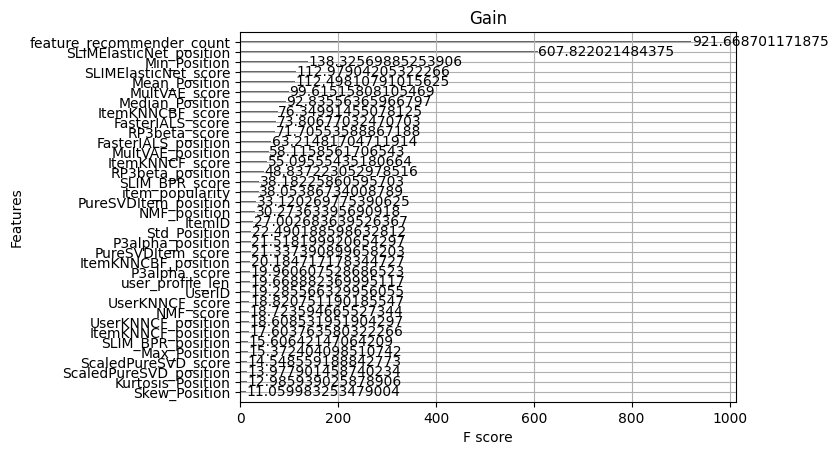

In [26]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='gain', title='Gain')

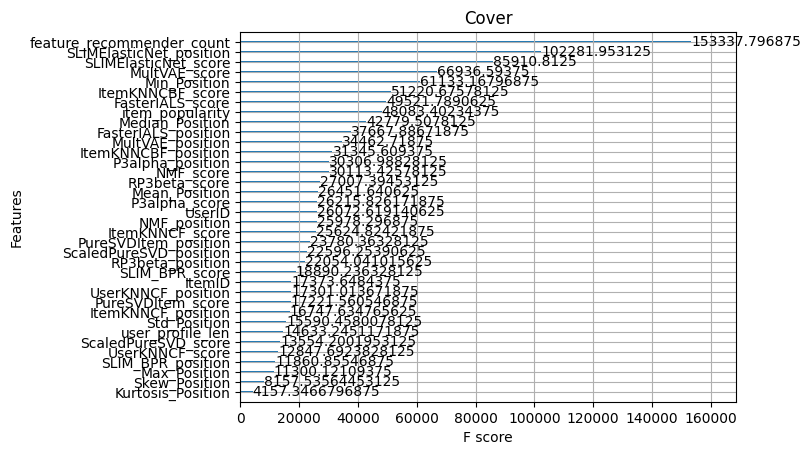

In [27]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='cover', title='Cover')

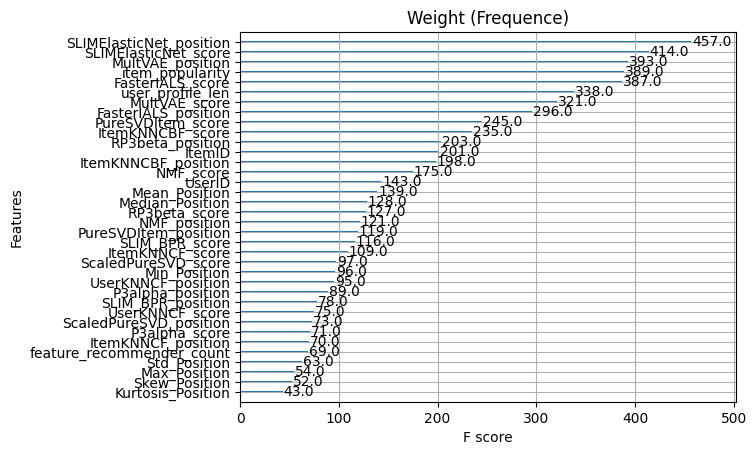

In [28]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='weight', title='Weight (Frequence)')

# Submission

Create the recommendations for the submission.

In [29]:
if config['tune_best_params']:

    data_target_users_test = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv')
    create_submission(data_target_users_test, recommender_instance, f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv')

Submission file saved as /kaggle/working/submission_XGBoostNoCont_MAP.csv


# Save Version on GitHub 

Write or import a json file where best hyperparameters are saved. 

In [30]:
if config['tune_parameters']:
    with open(f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 'w') as params_file:
        json.dump(optuna_study.best_params, params_file)
        
    if config['save_github']:
        upload_file(
            f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{config["model"]}_{config["metric"]} tuning results (from kaggle notebook)',
            repo
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/'\
        f'best_params_{config["model"]}_{config["metric"]}.json', 
        f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json'
    )

Save the history of the tuned model.

In [31]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'], 
        f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db',
        f'Tuning {config["model"]}_{config["metric"]} db updated results (from kaggle notebook)',
        repo
    )

Save the best trained model and its submission.

In [32]:
if config['save_github'] and config['tune_best_params']: 
    upload_file(
                f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv', 
                f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing_{config["metric"]}/Submission/submission_{config["model"]}_{config["metric"]}.csv', 
                f'New {config["model"]}_{config["metric"]} submission (from kaggle notebook)',
                repo
            )

File 'TrainedModels/WithoutKFCV/XGBoost/XGBoostNoContRecommender/Optimizing_MAP/Submission/submission_XGBoostNoCont_MAP.csv' created successfully.
